In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import patsy
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel import BetweenOLS, PooledOLS, compare

from linearmodels import IV2SLS

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})


In [3]:
data_path = os.path.join(output_filepath, 'panel_data.parquet')
df_model = pd.read_parquet(data_path)

df_model = df_model[df_model.year.between(2001, 2016)]

df_model['human_authorities_cero'] = np.isclose(df_model.human_authorities, 0)
df_model['receiving_cuntries'] = df_model.groupby('country').human_authorities_cero.transform(lambda x: sum(x)<len(x))
#df_model = df_model[df_model.receiving_cuntries]

centralities = ['hubs', 'authorities','pagerank', 'gfi', 'bridging', 'favor']

In [4]:
df_model[df_model.receiving_cuntries].country.unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CHL', 'CZE', 'DEU', 'DNK',
       'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IRL', 'ISL',
       'ISR', 'ITA', 'JPN', 'KOR', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR',
       'NZL', 'POL', 'PRT', 'SVK', 'SVN', 'SWE', 'TUR', 'USA'],
      dtype=object)

In [5]:
corr_cols = ['log_output', 'log_gdp', 'gini', 'log_GFCF', 'log_wkn_population'] + ['financial_' + c for c in centralities] +  ['goods_' + c for c in centralities]  + ['human_' + c for c in centralities]

for c in ['financial_' + c for c in centralities] + ['goods_' + c for c in centralities] + ['human_' + c for c in centralities]:
    df_model[c] = df_model[c].map(lambda x: np.log1p(x*1.e8))

df_model[['country', 'year'] + corr_cols].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,2731,171,BGD,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,2731,NaN,NaN,NaN,2008.49,4.60842,2001,2004,2008,2012,2016
log_output,2731,NaN,NaN,NaN,17.9249,2.23266,10.8685,16.3944,17.6934,19.6174,24.1941
log_gdp,2731,NaN,NaN,NaN,17.1583,2.32031,7.3328,15.6644,16.9492,18.884,23.5039
gini,359,NaN,NaN,NaN,0.319203,0.0594887,0.234,0.2695,0.315,0.348,0.62
log_GFCF,2511,NaN,NaN,NaN,22.8906,2.58599,0,21.468,22.7439,24.5476,29.1997
log_wkn_population,2731,NaN,NaN,NaN,15.1326,1.71139,10.7088,14.1218,15.1731,16.2155,20.4811
financial_hubs,2731,NaN,NaN,NaN,12.8838,0.71538,10.2929,12.3853,12.8415,13.3716,15.8608
financial_authorities,2731,NaN,NaN,NaN,12.7628,0.833117,9.17737,12.2082,12.6675,13.2038,16.2506
financial_pagerank,2731,NaN,NaN,NaN,12.862,0.665145,11.3178,12.4932,12.6858,13.0517,16.1921


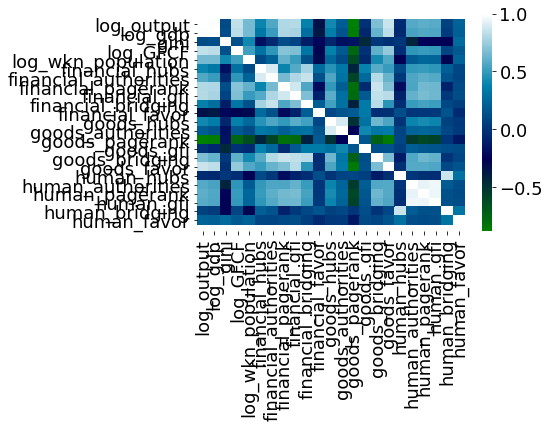

In [6]:
plt.rcParams.update({'font.size': 18})

corr = df_model[corr_cols].corr()

# plot the heatmap
sns.heatmap(corr, cmap="ocean",
        xticklabels=corr.columns,
        yticklabels=corr.columns,)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.7 # Add 0.5 to the bottom
t -= 0.7 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

## Variable selection
Some of the social capital variables we want to include are highly correlated --> need to reduce dimensionality in order to avoid multicolinearity


In [7]:
all_terms_list = ['financial_' + c for c in centralities] + ['human_' + c for c in centralities] + ['goods_' + c for c in centralities]

In [8]:
from scipy.stats import pearsonr
import statsmodels.api as sm

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    plt.rcParams.update({'font.size': 15})

    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.5, .1), xycoords=ax.transAxes)

def r2func(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    plt.rcParams.update({'font.size': 15})

    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    r2 = results.rsquared

    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    ax.annotate(f'$R^2$= {r2:.2f}', xy=(.5, .1), xycoords=ax.transAxes)



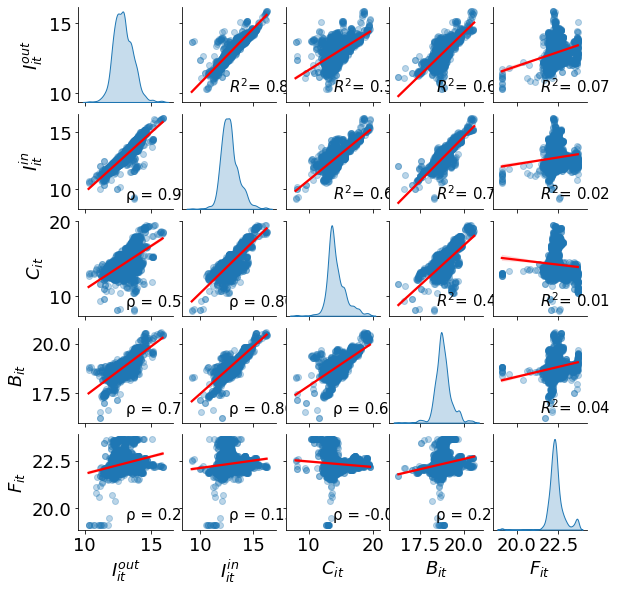

In [9]:
corr_cols = ['financial_' + c for c in ['hubs', 'authorities', 'gfi', 'bridging', 'favor']] 

plt.rcParams.update({'font.size': 18})

g = sns.pairplot(df_model[corr_cols], kind='reg', diag_kind = 'kde', plot_kws={'scatter_kws': {'alpha': 0.3}, 'line_kws':{'color':'red'}})
g.fig.set_size_inches(8,8)
g.map_lower(corrfunc)
g.map_upper(r2func)

names = dict(zip(corr_cols, ['$I_{it}^{out}$', '$I_{it}^{in}$', '$C_{it}$', '$B_{it}$', '$F_{it}$'] ))

plt.rcParams.update({'font.size': 18})
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in names.keys():
            g.axes[i][j].set_xlabel(names[xlabel])
        if ylabel in names.keys():
            g.axes[i][j].set_ylabel(names[ylabel])

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', 'financial_social_capital_multicolinearity.png')
plt.savefig(save_to)    
plt.show()

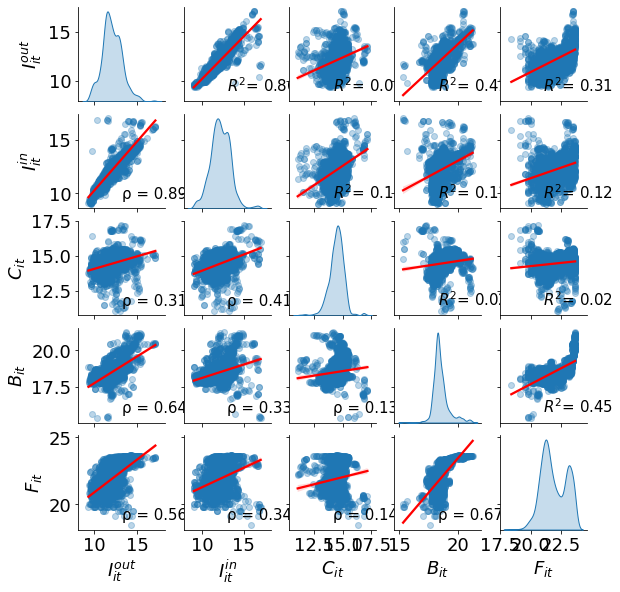

In [10]:
corr_cols = ['goods_' + c for c in ['hubs', 'authorities', 'gfi', 'bridging', 'favor']] 

plt.rcParams.update({'font.size': 18})

g = sns.pairplot(df_model[corr_cols], kind='reg', diag_kind = 'kde', plot_kws={'scatter_kws': {'alpha': 0.3}, 'line_kws':{'color':'red'}})
g.fig.set_size_inches(8,8)
g.map_lower(corrfunc)
g.map_upper(r2func)

names = dict(zip(corr_cols, ['$I_{it}^{out}$', '$I_{it}^{in}$', '$C_{it}$', '$B_{it}$', '$F_{it}$'] ))

plt.rcParams.update({'font.size': 18})
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in names.keys():
            g.axes[i][j].set_xlabel(names[xlabel])
        if ylabel in names.keys():
            g.axes[i][j].set_ylabel(names[ylabel])

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', 'financial_social_capital_multicolinearity.png')
plt.savefig(save_to)    
plt.show()

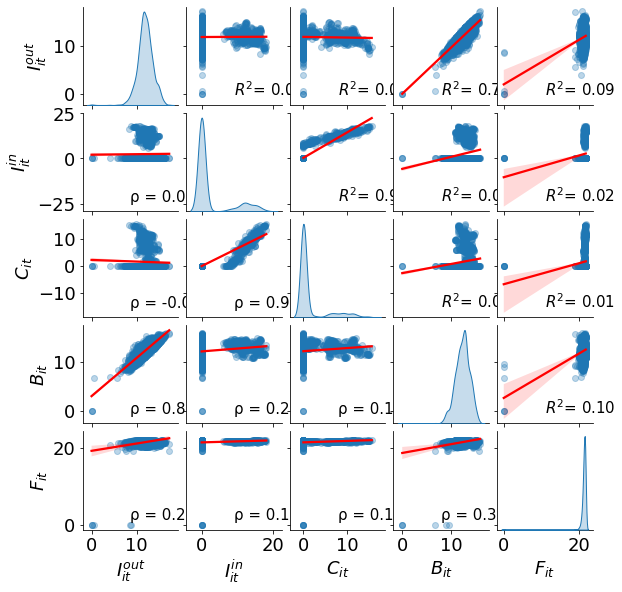

In [11]:
corr_cols = ['human_' + c for c in ['hubs', 'authorities', 'gfi', 'bridging', 'favor']] 

plt.rcParams.update({'font.size': 18})

g = sns.pairplot(df_model[corr_cols], kind='reg', diag_kind = 'kde', plot_kws={'scatter_kws': {'alpha': 0.3}, 'line_kws':{'color':'red'}})
g.fig.set_size_inches(8,8)
g.map_lower(corrfunc)
g.map_upper(r2func)

names = dict(zip(corr_cols, ['$I_{it}^{out}$', '$I_{it}^{in}$', '$C_{it}$', '$B_{it}$', '$F_{it}$'] ))

plt.rcParams.update({'font.size': 18})
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in names.keys():
            g.axes[i][j].set_xlabel(names[xlabel])
        if ylabel in names.keys():
            g.axes[i][j].set_ylabel(names[ylabel])

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', 'financial_social_capital_multicolinearity.png')
plt.savefig(save_to)    
plt.show()

## Simultaneous model capital and migration

In [12]:
all_terms_regression = ' + '.join(all_terms_list)

In [13]:
f = f'log_gdp ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = RandomEffects(y,X)

be_res = BetweenOLS(y,X)
be_res = be_res.fit()

model = PooledOLS(y,X)
pooled_res = model.fit()

model = RandomEffects(y,X)
re_res = model.fit()

compare({'BE':be_res,'RE':re_res,'Pooled':pooled_res})

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


,BE,RE,Pooled
Dep. Variable,log_gdp,log_gdp,log_gdp
Estimator,BetweenOLS,RandomEffects,PooledOLS
No. Observations,163,2511,2511
Cov. Est.,Unadjusted,Unadjusted,Unadjusted
R-squared,0.9733,0.7812,0.9457
R-Squared (Within),0.3465,0.7019,0.5186
R-Squared (Between),0.9733,0.8890,0.9708
R-Squared (Overall),0.9389,0.8757,0.9457
F-statistic,259.05,444.45,2166.4
P-value (F-stat),0.0000,0.0000,0.0000


## Stacked results

In [14]:
def stacked_results(y_label, centralities, estimator = RandomEffects):

    X_terms_list = ['financial_' + c for c in centralities] + ['goods_' + c for c in centralities] + ['human_' + c for c in centralities]
    all_terms_regression = ' + '.join(X_terms_list)
    f = f'{y_label} ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
    y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
    model = estimator(y,X)
    results_combined_model = model.fit()

    df_results = pd.DataFrame(results_combined_model.params).reset_index()
    df_results['pvalues'] = results_combined_model.pvalues.values
    df_results['show_value'] = df_results.apply(lambda x: f'{round(x.parameter,4)} ({round(x.pvalues, 5)})', axis=1)
    df_results = df_results[~df_results['index'].isin(['Intercept','log_GFCF','log_wkn_population'])]
    df_results['network'], df_results['capital'] = zip(*df_results['index'].map(lambda x: (x.split('_')[0], x.split('_')[1])))
    print(f'''Results regression analysis: {y_label} ''')
    df_results = df_results.pivot_table(index='network', columns = 'capital', values = 'show_value', aggfunc=np.unique)
    
    return df_results

stacked_results('log_gdp', centralities)

Results regression analysis: log_gdp 


capital,authorities,bridging,favor,gfi,hubs,pagerank
network,,,,,,
financial,-0.6187 (0.0),-1.6577 (0.0),-0.1127 (0.02529),-0.0941 (0.01478),0.6874 (0.0),1.7561 (0.0)
goods,0.4157 (0.0),1.1784 (0.0),0.8599 (0.0),-0.1243 (0.00177),-0.6684 (0.0),0.0146 (0.87074)
human,0.0385 (0.00023),0.0229 (0.19019),0.0229 (0.01148),0.0161 (0.39285),0.0324 (0.00477),-0.112 (0.01375)


In [15]:
stacked_results('gini', centralities)

Results regression analysis: gini 


/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


capital,authorities,bridging,favor,gfi,hubs,pagerank
network,,,,,,
financial,-0.0169 (0.54741),0.0069 (0.77831),-0.0358 (0.20559),0.0275 (0.01448),0.0204 (0.43051),-0.0435 (0.01509)
goods,0.0033 (0.39447),-0.0188 (0.35566),-0.0106 (0.44169),-0.0213 (0.03339),-0.004 (0.36733),0.0327 (0.16562)
human,0.0008 (0.25003),-0.0017 (0.62611),-0.0231 (0.1504),-0.0017 (0.20034),0.0032 (0.03775),0.0005 (0.89809)


In [16]:
reduced_centralities = ['hubs', 'authorities', 'favor']
stacked_results('log_gdp', reduced_centralities)

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


Results regression analysis: log_gdp 


capital,authorities,favor,hubs
network,,,
financial,0.5687 (0.0),-0.4542 (0.0),-0.8419 (0.0)
goods,0.4268 (0.0),0.822 (0.0),-0.6733 (0.0)
human,0.0546 (0.0),0.0449 (0.0),0.004 (0.70119)


In [17]:
stacked_results('gini', reduced_centralities)

Results regression analysis: gini 


/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


capital,authorities,favor,hubs
network,,,
financial,-0.0284 (0.11523),-0.0467 (0.03669),0.0237 (0.20153)
goods,0.002 (0.58934),-0.0033 (0.77921),-0.0017 (0.69685)
human,-0.0001 (0.78149),-0.0342 (0.01286),0.0036 (0.00919)


## MODEL COMPARISON

In [18]:
all_terms_regression = ' + '.join(all_terms_list)
reduced_terms_list = ['financial_' + c for c in reduced_centralities] + ['goods_' + c for c in reduced_centralities] + ['human_' + c for c in reduced_centralities]
reduced_terms_list = ['financial_hubs', 
                      'financial_authorities', 
                      'goods_hubs', 
                      'goods_authorities', 
                      'human_hubs', 
                      'human_authorities',
                      'human_favor']

reduced_terms_regression = ' + '.join(reduced_terms_list)


In [19]:
f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model = RandomEffects(y,X)
base_model = base_model.fit()

f = f'log_gdp ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
full_model = RandomEffects(y,X)
full_model = full_model.fit()

f = f'log_gdp ~ {reduced_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
reduced_model = RandomEffects(y,X)
reduced_model = reduced_model.fit()

c = compare({'Base Model':base_model,
             #'Full Model':full_model, 
             'Reduced Model':reduced_model}, precision='pvalues')
#print(c.summary.as_latex())
c.summary

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


,Base Model,Reduced Model
Dep. Variable,log_gdp,log_gdp
Estimator,RandomEffects,RandomEffects
No. Observations,2511,2511
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.4537,0.5597
R-Squared (Within),0.4178,0.5415
R-Squared (Between),0.5510,0.5845
R-Squared (Overall),0.5338,0.5746
F-statistic,1041.4,353.19
P-value (F-stat),0.0000,0.0000


## VIF

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(df_model[reduced_terms_list].values, i) for i in range(len(reduced_terms_list))]

print(vif)

[2825.0888786835644, 3253.5038974405397, 1619.4323134938106, 1158.2848999837577, 60.09384425167593, 1.5372604476434848, 256.3412635389953]


## PCA variables

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

n = 3

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

all_terms = [[n + '_' + c for c in centralities] for n in ['financial', 'human']]
all_terms = [item for sublist in all_terms for item in sublist]
all_terms = reduced_terms_list.copy()
df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[all_terms])

print(pipe['reduce_dims'].explained_variance_ratio_)
print(pipe['reduce_dims'].components_)

[0.44480603 0.18592237 0.16281635]
[[ 0.47270053  0.49107721  0.47303982  0.39441415  0.06018646  0.38094333
   0.08560356]
 [-0.11710604 -0.05428102  0.24613496  0.23384496 -0.64584816 -0.08061592
  -0.66667465]
 [ 0.33525134  0.36641915 -0.39791272 -0.60074088 -0.32127798  0.31748669
  -0.17349949]]


Text(0, 0.5, 'cumulative explained variance')

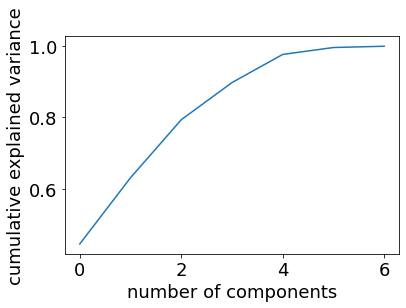

In [22]:
n = 7
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[all_terms])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [23]:
f = 'log_gdp ~ log_GFCF + log_wkn_population + 1 + ' + ' + '.join([f'pca_{i}' for i in range(n)])
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = RandomEffects(y,X)
results = model.fit()
results.summary

PatsyError: Error evaluating factor: NameError: name 'pca_6' is not defined
    log_gdp ~ log_GFCF + log_wkn_population + 1 + pca_0 + pca_1 + pca_2 + pca_3 + pca_4 + pca_5 + pca_6
                                                                                                  ^^^^^

In [ ]:
df_radar = pd.DataFrame(pipe['reduce_dims'].components_, columns = all_terms)
df_radar.loc[:,'coefs'] = pd.Series(results.params[[f'pca_{i}' for i in range(n)]].values)
df_radar['pvalues'] = pd.Series(results.pvalues[[f'pca_{i}' for i in range(n)]].values)

labels = all_terms.copy()
stats = pipe['reduce_dims'].components_[0]

angles=np.linspace(0, 2*np.pi, len(all_terms), endpoint=False)

fig=plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, polar=True)

for i in range(n):
    stats = df_radar.loc[i,all_terms]
    c = round(df_radar.loc[i,'coefs'], 3)
    p =  round(df_radar.loc[i,'pvalues'], 3)
    ax.plot(np.concatenate((angles,[angles[0]])), np.concatenate((stats,[stats[0]])), 
            'o-', 
            linewidth=2, 
            label = f'effect: {c} (p: {p})'
)
    ax.fill(angles, stats, alpha=0.25)
plt.legend()
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

## Time series

In [ ]:
lagged_all_terms_list = ['delta_financial_' + c for c in reduced_centralities] + ['delta_human_' + c for c in reduced_centralities]
lagged_all_terms_list = ' + '.join(lagged_all_terms_list)

In [ ]:
model = IV2SLS(df_model.delta_log_output, df_model[['financial_' + c for c in reduced_centralities] + ['human_' + c for c in reduced_centralities] + ['constant']], df_model.lag_log_output, df_model.lag_log2_output)
results = model.fit()
results.summary

In [ ]:
print(results.summary.as_latex())